## Подготовка данных

### Откроем файлы и изучим их.

Сперва импортируем все необходимые библиотеки и инструменты для выполнения задания.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

plt.rcParams["figure.figsize"] = (15, 8)
from sklearn.metrics import fbeta_score, make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

Откроем датасеты и привяжем их к именам.

In [2]:
gold_recovery_train_new= pd.read_csv('/datasets/gold_recovery_train_new.csv')
gold_recovery_test_new = pd.read_csv('/datasets/gold_recovery_test_new.csv')
gold_recovery_full_new = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
display(gold_recovery_train_new.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Определим размер датафреймов

In [4]:
print("Размер датафрейма gold_recovery_train_new", gold_recovery_train_new.shape)
print("Размер датафрейма gold_recovery_test_new", gold_recovery_test_new.shape)
print("Размер датафрейма gold_recovery_full_new", gold_recovery_full_new.shape)

Размер датафрейма gold_recovery_train_new (14149, 87)
Размер датафрейма gold_recovery_test_new (5290, 53)
Размер датафрейма gold_recovery_full_new (19439, 87)


### Проверим, что эффективность обогащения рассчитана правильно. 

Вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Опишите выводы.

In [5]:
C = gold_recovery_train_new["rougher.output.concentrate_au"]
F = gold_recovery_train_new["rougher.input.feed_au"]
T = gold_recovery_train_new["rougher.output.tail_au"]

recovery_calculated_au = (C * (F - T)) / (F * (C - T)) * 100

Сравним полученное значение с признаком "rougher.output.recovery".

In [6]:
print(
    "Средняя абсолютная ошибка:",
    mean_absolute_error(
        gold_recovery_train_new["rougher.output.recovery"], recovery_calculated_au
    ),
)

Средняя абсолютная ошибка: 9.73512347450521e-15


<b>Вывод:</b>
<br>Как можно заметить, значение MAE имеет очень маленькое значени, исходя из чего можно сделать вывод эффективность обогащения рассчитана правильно.

### Проанализируем признаки, недоступные в тестовой выборке. Определим, что это за параметры и к какому типу относятся.

Определим какие признаки есть в полном наборе данных, которые отсутствуют в тестовой.

In [7]:
# присвоим переменной difference_columns название признаков, которых нет в тестовом наборе данных

difference_columns = (gold_recovery_full_new.columns).difference(
    gold_recovery_test_new.columns
)

In [8]:
difference_columns.to_list()

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Как можно заметить в основном это признаки связанные с концентрацией металлов на различных этапах обработки и в отвальных хвостах.

Из датасета "gold_recovery_full_new" для дальнейшего обучения и проверки модели возьмем целевые признаки "target_rougher" и "target_final".

In [9]:
gold_recovery_test_new = gold_recovery_test_new.merge(
    gold_recovery_full_new[["date", "rougher.output.recovery", "final.output.recovery"]]
)
gold_recovery_test_new.shape

(5290, 55)

Убедимся, что целевые признаки перешли в тестовый набор данных. Рассмотрим первые 5 строк датасета.

In [10]:
gold_recovery_test_new.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


###  Проведем предобработку данных.

В данной преобработке выберем в обучающем наборе данных такие же признаки, что и в тестовом наборе.

In [11]:
# создадис переменную с названиями столбцов в тестовом наборе данных

name_columns_test = gold_recovery_test_new.columns

In [12]:
# с помошью loc создадим новый датафрейм из тренировочного датасета, с признаками из тренировочного датасета.

gold_recovery_train_new = gold_recovery_train_new.loc[ : , name_columns_test]

In [13]:
# проверим, что количетсво признаков тренировочного и тестового датафреймов одинаковые

print("Размер тренировочного набора данных", gold_recovery_train_new.shape)
print("Размер тестового набора данных", gold_recovery_test_new.shape)

Размер тренировочного набора данных (14149, 55)
Размер тестового набора данных (5290, 55)


In [14]:
# выведем 5 первых строк тренировочного датафрейма

gold_recovery_train_new.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,68.347543
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,66.927016


In [15]:
# проверим наличие пропусков

gold_recovery_train_new.isna().sum()

date                                            0
primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29


Заполним пропуски методом fillna().

In [16]:
gold_recovery_train_new = gold_recovery_train_new.fillna(method="ffill")
gold_recovery_test_new = gold_recovery_test_new.fillna(method="ffill")

## Анализ данных

### Рассмотрим изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

Рассмотрим изменение концентрации золота на различных этапах очистки, в порядке следования (до обработки, после флотации, после пер). Для оценки концентрации возьмем медианное значение признака.

In [17]:
print(
    "Концентрация золота до обработки",
    gold_recovery_full_new["rougher.input.feed_au"].median(),
)
print(
    "Концентрация золота после флотации",
    gold_recovery_full_new["rougher.output.concentrate_au"].median(),
)
print(
    "Концентрация золота после первичной очистки",
    gold_recovery_full_new["primary_cleaner.output.concentrate_au"].median(),
)
print(
    "Финальная концентрация золота",
    gold_recovery_full_new["final.output.concentrate_au"].median(),
)

Концентрация золота до обработки 8.125838836648287
Концентрация золота после флотации 20.280214025891475
Концентрация золота после первичной очистки 32.841295480233306
Финальная концентрация золота 45.01124391455689


Рассмотрим изменение концентрации серебра на различных этапах очистки

In [18]:
print(
    "Концентрация серебра до обработки",
    gold_recovery_full_new["rougher.input.feed_ag"].median(),
)
print(
    "Концентрация серебра после флотации",
    gold_recovery_full_new["rougher.output.concentrate_ag"].median(),
)
print(
    "Концентрация серебра после первичной очистки",
    gold_recovery_full_new["primary_cleaner.output.concentrate_ag"].median(),
)
print(
    "Финальная концентрация серебра",
    gold_recovery_full_new["final.output.concentrate_ag"].median(),
)

Концентрация серебра до обработки 8.593574167368724
Концентрация серебра после флотации 12.098114967346191
Концентрация серебра после первичной очистки 8.507297972365805
Финальная концентрация серебра 5.066093965863015


Рассмотрим изменение концентрации олова на различных этапах очистки

In [19]:
print(
    "Концентрация олова до обработки",
    gold_recovery_full_new["rougher.input.feed_pb"].median(),
)
print(
    "Концентрация олова после флотации",
    gold_recovery_full_new["rougher.output.concentrate_pb"].median(),
)
print(
    "Концентрация олова после первичной очистки",
    gold_recovery_full_new["primary_cleaner.output.concentrate_pb"].median(),
)
print(
    "Финальная концентрация олова",
    gold_recovery_full_new["final.output.concentrate_pb"].median(),
)

Концентрация олова до обработки 3.5348947581979964
Концентрация олова после флотации 7.742580079502529
Концентрация олова после первичной очистки 10.152432639333936
Финальная концентрация олова 10.102432534297307


<b>Вывод:</b>
<br>Как можно заметить, концентрация золота после каждого этапа возрастает, несмотря на то, что после каждого этапа образуются отвальные хвосты. Напротив, концентрация серебра снижается после первичной очистки вплоть до измерения финальной концентрации. Можно сделать вывод, что первичная очистка применяет неправильные методы обработки сырья. Также можно заметить, что финальная концентрация олова ниже, чем после первичной очистки, что также можно связать с применяемыми методами.

Построим графики распределения для концетраций на различных этапах обработки для веществ Au, Ag, Pb.

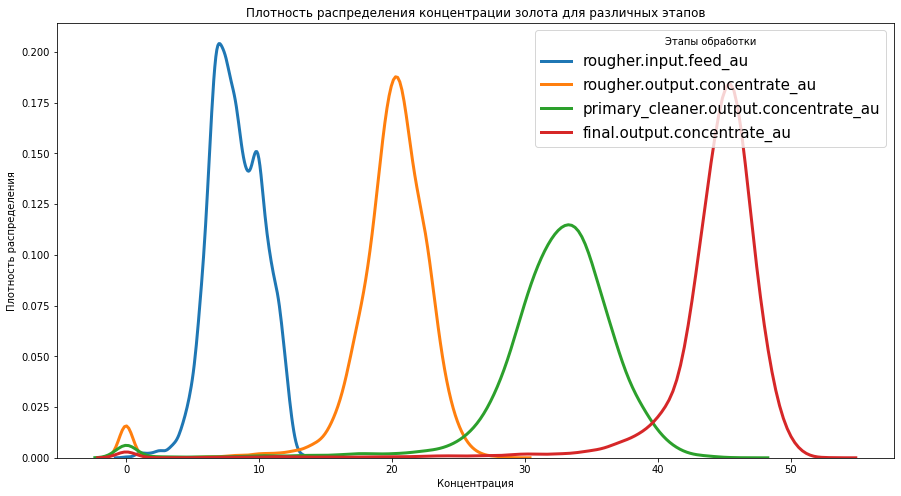

In [20]:
# построим график распределения для концентраций золота на различных этапах обработки

warnings.simplefilter(action="ignore", category=FutureWarning)

# лист этапов обработки
steps = [
    "rougher.input.feed_au",
    "rougher.output.concentrate_au",
    "primary_cleaner.output.concentrate_au",
    "final.output.concentrate_au",
]

# итерации для различных этапов обработки
for step in steps:
    # Subset to the airline
    subset = gold_recovery_full_new[step]

    # Draw the density plot
    sns.distplot(subset, hist=False, kde=True, kde_kws={"linewidth": 3}, label=step)

# оформление графика
plt.legend(prop={"size": 15}, title="Этапы обработки")
plt.title("Плотность распределения концентрации золота для различных этапов")
plt.xlabel("Концентрация")
plt.ylabel("Плотность распределения")
plt.show()

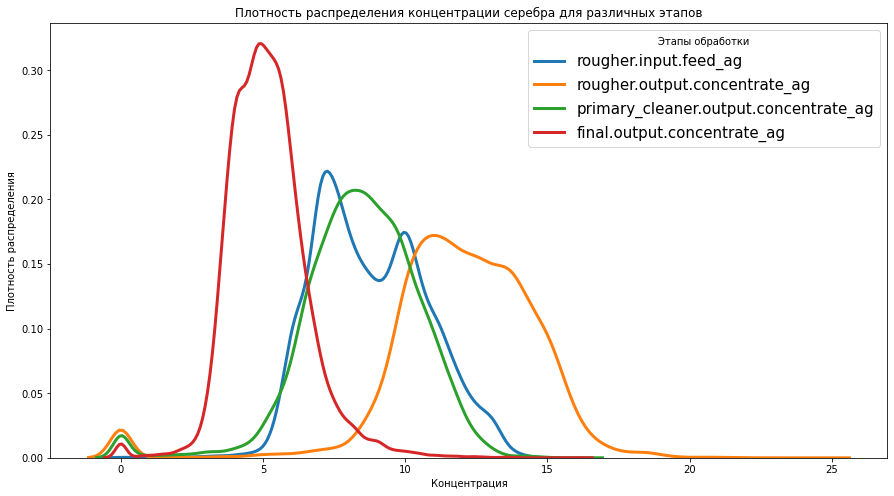

In [21]:
# построим график распределения для концентраций серебра на различных этапах обработки

warnings.simplefilter(action="ignore", category=FutureWarning)

# лист этапов обработки
steps = [
    "rougher.input.feed_ag",
    "rougher.output.concentrate_ag",
    "primary_cleaner.output.concentrate_ag",
    "final.output.concentrate_ag",
]

# итерации для различных этапов обработки
for step in steps:
    # Subset to the airline
    subset = gold_recovery_full_new[step]

    # Draw the density plot
    sns.distplot(subset, hist=False, kde=True, kde_kws={"linewidth": 3}, label=step)

# оформление графика
plt.legend(prop={"size": 15}, title="Этапы обработки")
plt.title("Плотность распределения концентрации серебра для различных этапов")
plt.xlabel("Концентрация")
plt.ylabel("Плотность распределения")
plt.show()

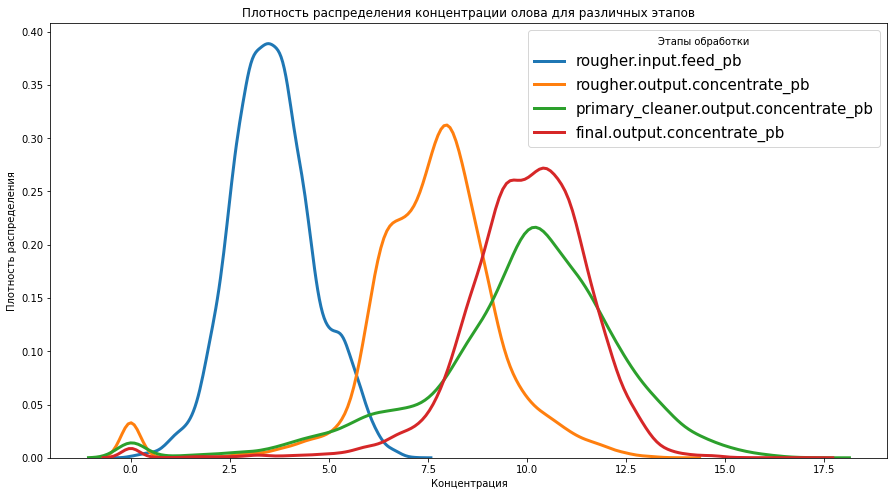

In [22]:
# построим график распределения для концентраций золота на различных этапах обработки

warnings.simplefilter(action="ignore", category=FutureWarning)

# лист этапов обработки
steps = [
    "rougher.input.feed_pb",
    "rougher.output.concentrate_pb",
    "primary_cleaner.output.concentrate_pb",
    "final.output.concentrate_pb",
]

# итерации для различных этапов обработки
for step in steps:
    # Subset to the airline
    subset = gold_recovery_full_new[step]

    # Draw the density plot
    sns.distplot(subset, hist=False, kde=True, kde_kws={"linewidth": 3}, label=step)

# оформление графика
plt.legend(prop={"size": 15}, title="Этапы обработки")
plt.title("Плотность распределения концентрации олова для различных этапов")
plt.xlabel("Концентрация")
plt.ylabel("Плотность распределения")
plt.show()

<b>Вывод:</b>
<br>Анализируя графики распределения для концетраций на различных этапах обработки для веществ Au, Ag и Pb можно сделать вывод, что наиболее нормальное распределение имеет вещество Au, его концентрация растет с каждым этапом. Вещество Ag имеет близкое к нормальному распределению плотность только после последнего этапа обработки, а также наименьшее значение концентрации после всех этапов обработки. Концентрация вещества Pb растет и его график распределение стремится к нормальному распределению. 

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

Для сравнения распределения размеров гранул до флотации (признак "rougher.input.feed_size") и после первичной очистки (признак "primary_cleaner.input.feed_size") воспользуемся инструментов pandas.DataFrame.plot.kde. Данный инструмент  — это непараметрический способ оценки функции плотности вероятности случайной величины или нескольких величин. В данном случае мы оценим один признак для двух наборов данных, обучающей и тестовой.

Оценим плотности веростности признака "rougher.input.feed_size".

In [23]:
train_test_rougher_input_feed_size = pd.DataFrame()
train_test_rougher_input_feed_size["train_size"] = gold_recovery_train_new[
    "rougher.input.feed_size"
]
train_test_rougher_input_feed_size["test_size"] = gold_recovery_test_new[
    "rougher.input.feed_size"
]

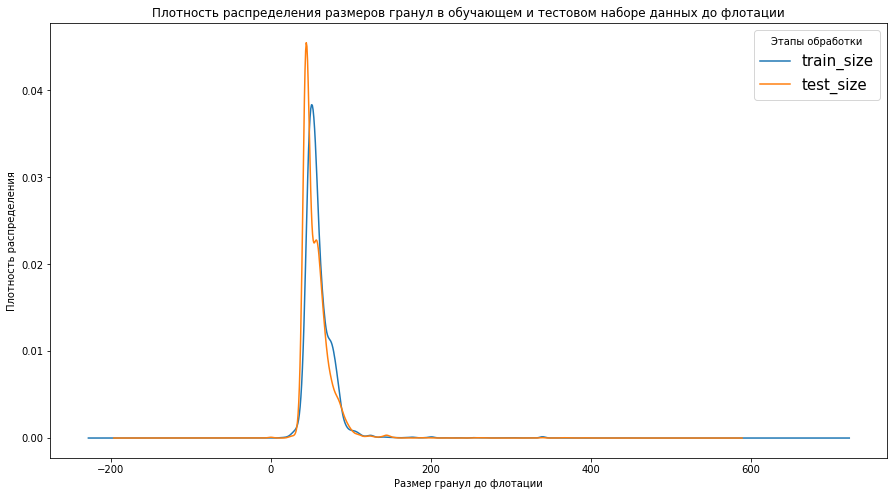

In [24]:
train_test_rougher_input_feed_size.plot.kde()
plt.legend(prop={"size": 15}, title="Этапы обработки")
plt.title(
    "Плотность распределения размеров гранул в обучающем и тестовом наборе данных до флотации"
)
plt.xlabel("Размер гранул до флотации")
plt.ylabel("Плотность распределения")
plt.show()

Оценим плотности веростности признака "primary_cleaner.input.feed_size".

In [25]:
train_test_primary_cleaner_input_feed_size = pd.DataFrame()
train_test_primary_cleaner_input_feed_size["train_size"] = gold_recovery_train_new[
    "primary_cleaner.input.feed_size"
]
train_test_primary_cleaner_input_feed_size["test_size"] = gold_recovery_test_new[
    "primary_cleaner.input.feed_size"
]

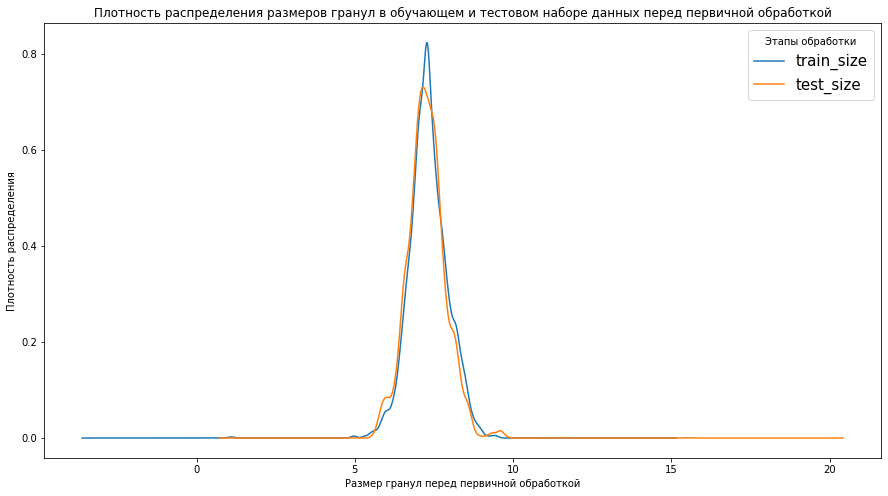

In [26]:
train_test_primary_cleaner_input_feed_size.plot.kde()
plt.legend(prop={"size": 15}, title="Этапы обработки")
plt.title(
    "Плотность распределения размеров гранул в обучающем и тестовом наборе данных перед первичной обработкой"
)
plt.xlabel("Размер гранул перед первичной обработкой")
plt.ylabel("Плотность распределения")
plt.show()

<b>Вывод:</b>
<br>Распределение плотности вероятности для двух признаков для двух наборов данных практически не отличаются друг от друга. 

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

Для исследования построим гистограммы распределения для суммарной концетранции веществ на стадии перед флотацией.

In [27]:
# просуммируем все значения концентраций для веществ в переменную rougher_input_feed_sum

rougher_input_feed_sum = (
    gold_recovery_full_new["rougher.input.feed_au"]
    + gold_recovery_full_new["rougher.input.feed_pb"]
    + gold_recovery_full_new["rougher.input.feed_sol"]
    + gold_recovery_full_new["rougher.input.feed_ag"]
)

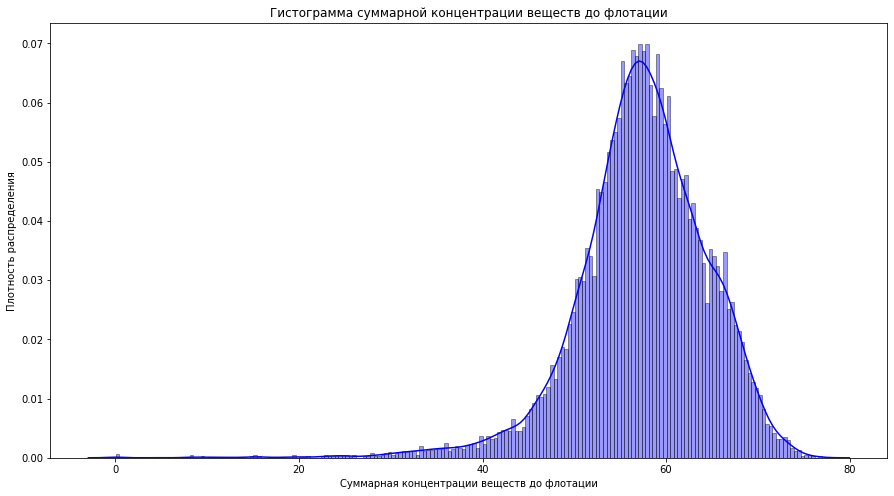

In [28]:
# построим гистограмму для переменной rougher_input_feed_sum

warnings.simplefilter(action="ignore", category=FutureWarning)

# построение гистограммы через seaborn
sns.distplot(
    rougher_input_feed_sum,
    hist=True,
    kde=True,
    bins=200,
    color="blue",
    hist_kws={"edgecolor": "black"},
)

# название осей
plt.title("Гистограмма суммарной концентрации веществ до флотации")
plt.xlabel("Суммарная концентрации веществ до флотации")
plt.ylabel("Плотность распределения")
plt.show()

Методом describe() рассмотрим, есть ли отрицательные значения в данной выборке.

In [29]:
rougher_input_feed_sum.describe()

count    19245.000000
mean        57.407926
std          7.165219
min          0.040000
25%         53.660745
50%         57.647093
75%         62.012223
max         76.978947
dtype: float64

Как можно заметить отрицательных значений нет.

Проведем исследования для других стадей. Например проверим концетрацию веществ после флотации.

In [30]:
rougher_output_concentrate_sum = (
    gold_recovery_full_new["rougher.output.concentrate_au"]
    + gold_recovery_full_new["rougher.output.concentrate_pb"]
    + gold_recovery_full_new["rougher.output.concentrate_sol"]
    + gold_recovery_full_new["rougher.output.concentrate_ag"]
)

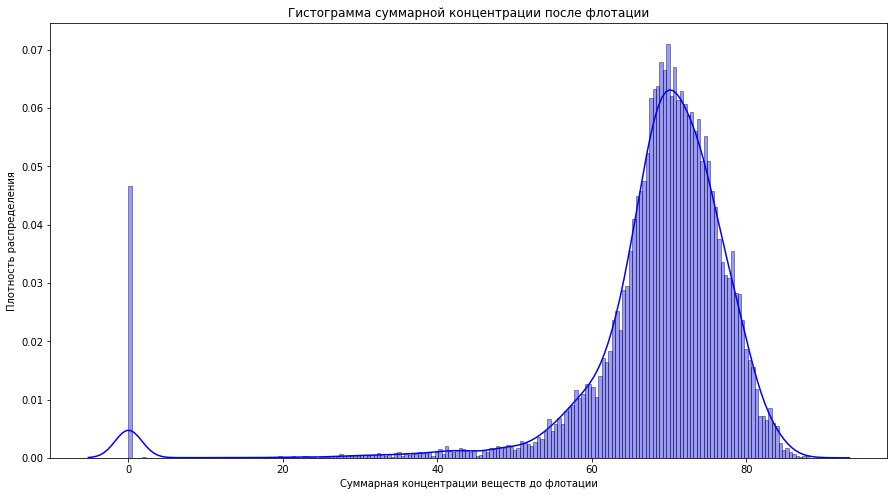

In [31]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# seaborn histogram
sns.distplot(
    rougher_output_concentrate_sum,
    hist=True,
    kde=True,
    bins=200,
    color="blue",
    hist_kws={"edgecolor": "black"},
)

# Add labels
plt.title("Гистограмма суммарной концентрации после флотации")
plt.xlabel("Суммарная концентрации веществ до флотации")
plt.ylabel("Плотность распределения")
plt.show()

In [32]:
# уберем выбросы около 0 в полном наборе данных

gold_recovery_full_new = gold_recovery_full_new.loc[rougher_output_concentrate_sum > 10]

In [33]:
rougher_output_concentrate_sum = (
    gold_recovery_full_new["rougher.output.concentrate_au"]
    + gold_recovery_full_new["rougher.output.concentrate_pb"]
    + gold_recovery_full_new["rougher.output.concentrate_sol"]
    + gold_recovery_full_new["rougher.output.concentrate_ag"]
)

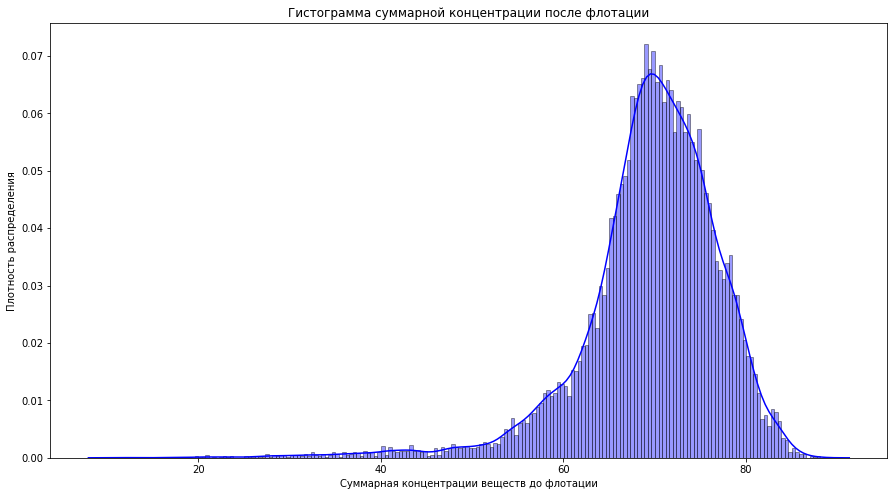

In [34]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# seaborn histogram
sns.distplot(
    rougher_output_concentrate_sum,
    hist=True,
    kde=True,
    bins=200,
    color="blue",
    hist_kws={"edgecolor": "black"},
)

# Add labels
plt.title("Гистограмма суммарной концентрации после флотации")
plt.xlabel("Суммарная концентрации веществ до флотации")
plt.ylabel("Плотность распределения")
plt.show()

Основные значения сосредоточены на значениях 60-80. Выбросов и аномальных значений не обнаружено.

Рассмотрим концентрацию веществ после всех этапов обработки.

In [35]:
final_output_concentrate_sum = (
    gold_recovery_full_new["final.output.concentrate_au"]
    + gold_recovery_full_new["final.output.concentrate_pb"]
    + gold_recovery_full_new["final.output.concentrate_sol"]
    + gold_recovery_full_new["final.output.concentrate_ag"]
)

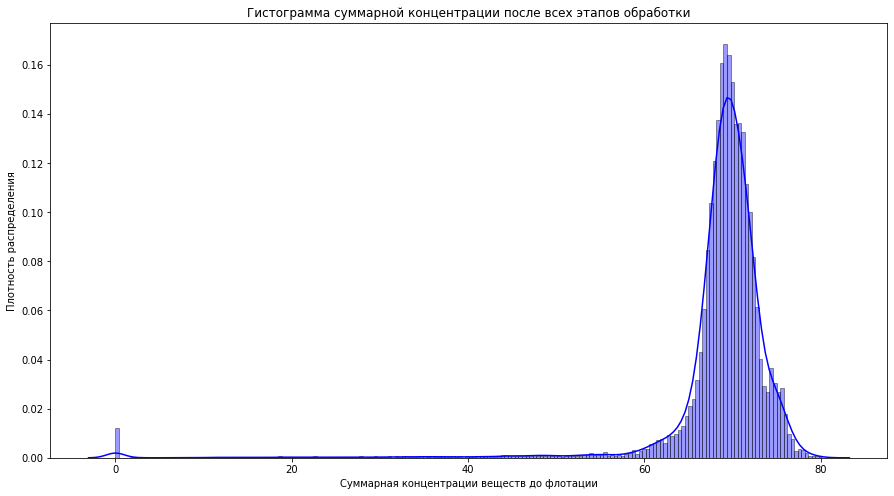

In [36]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# seaborn histogram
sns.distplot(
    final_output_concentrate_sum,
    hist=True,
    kde=True,
    bins=200,
    color="blue",
    hist_kws={"edgecolor": "black"},
)

# Add labels
plt.title("Гистограмма суммарной концентрации после всех этапов обработки")
plt.xlabel("Суммарная концентрации веществ до флотации")
plt.ylabel("Плотность распределения")
plt.show()

In [37]:
# уберем выбросы около 0

gold_recovery_full_new = gold_recovery_full_new.loc[final_output_concentrate_sum > 10]

In [38]:
final_output_concentrate_sum = (
    gold_recovery_full_new["final.output.concentrate_au"]
    + gold_recovery_full_new["final.output.concentrate_pb"]
    + gold_recovery_full_new["final.output.concentrate_sol"]
    + gold_recovery_full_new["final.output.concentrate_ag"]
)

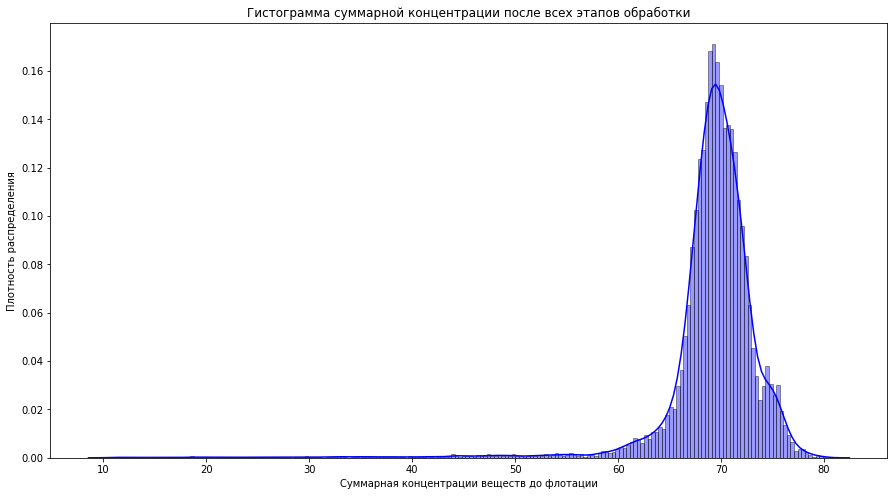

In [39]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# seaborn histogram
sns.distplot(
    final_output_concentrate_sum,
    hist=True,
    kde=True,
    bins=200,
    color="blue",
    hist_kws={"edgecolor": "black"},
)

# Add labels
# Add labels
plt.title("Гистограмма суммарной концентрации после всех этапов обработки")
plt.xlabel("Суммарная концентрации веществ до флотации")
plt.ylabel("Плотность распределения")
plt.show()

In [40]:
print("Размер обучающего датасета до обработки", gold_recovery_train_new.shape)
gold_recovery_train_new = gold_recovery_train_new.merge(
    gold_recovery_full_new[["date"]]
)
print("Размер обучающего датасета после обработки", gold_recovery_train_new.shape)

Размер обучающего датасета до обработки (14149, 55)
Размер обучающего датасета после обработки (13554, 55)


Основные значения сосредоточены на значениях 65-75. Выбросов и аномальных значений не обнаружено.

## Модель

### Напишем функцию для вычисления итоговой sMAPE.

In [41]:
def smape(a, f):
    return 1 / len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)) * 100)

In [42]:
def smape_final(smape_r, smape_f):

    smape_final = 0.25 * smape_r + 0.75 * smape_f

    return smape_final

###  Обучим разные модели и оцени их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. 

Оценим модель "решающее дерево" с помощью промежуточной оценки через кросс-валидацую для двух целевых признаков 'rougher.output.recovery', 'final.output.recovery'. 

In [43]:
# разделим набор данных на признаки и целевые признаки

features_train_rougher = gold_recovery_train_new.drop(
    ["date", "rougher.output.recovery", "final.output.recovery"], axis=1
)
target_train_rougher = gold_recovery_train_new["rougher.output.recovery"]
target_train_final = gold_recovery_train_new["final.output.recovery"]

features_test_rougher = gold_recovery_test_new.drop(
    ["date", "rougher.output.recovery", "final.output.recovery"], axis=1
)
target_test_rougher = gold_recovery_test_new["rougher.output.recovery"]
target_test_final = gold_recovery_test_new["final.output.recovery"]

In [44]:
# создадим свой собственный scorer

smape_scorer = make_scorer(smape, greater_is_better = False)

In [45]:
# определим лучшие параметры модели DecisionTreeRegressor и оценим модель кросс-валидацией для таргета "rougher.output.recovery"

dtr = DecisionTreeRegressor(random_state=12345)
parametrs = {"max_depth": range(1, 8), "min_samples_split": range(2, 10, 2)}
grid = GridSearchCV(dtr, parametrs, cv=5, n_jobs=-1, verbose=10, scoring=smape_scorer)
grid.fit(features_train_rougher, target_train_rougher)
grid.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 1/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 2/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 2/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 3/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 3/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 4/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 4/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 5/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 5/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 1/5; 2/28] START max_depth=1, min_samples_split=4...........................
[CV 1/5; 2/28] END .........max_depth=1, min_sa

{'max_depth': 3, 'min_samples_split': 2}

In [46]:
# оценим модель через кросс-валидацию с таргетом "rougher.output.recovery" с лучшими параметрами модели

score_rougher = - grid.best_score_
print('Оценка на кросс-валидации для таргета "rougher.output.recovery"', score_rougher)

Оценка на кросс-валидации для таргета "rougher.output.recovery" 7.3588443199216


In [47]:
# определим лучшие параметры модели DecisionTreeRegressor и оценим модель кросс-валидацией для таргета "final.output.recovery"

grid.fit(features_train_rougher, target_train_final)
grid.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 1/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 2/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 2/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 3/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 3/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 4/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 4/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 5/5; 1/28] START max_depth=1, min_samples_split=2...........................
[CV 5/5; 1/28] END .........max_depth=1, min_samples_split=2; total time=   0.1s
[CV 1/5; 2/28] START max_depth=1, min_samples_split=4...........................
[CV 1/5; 2/28] END .........max_depth=1, min_sa

{'max_depth': 2, 'min_samples_split': 2}

In [48]:
# рассчитаем метрике МАЕ и кросс-валидацию для для таргета "final.output.recovery" с лучшими параметрами модели
# оценим модель через кросс-валидацию с таргетом "final.output.recovery" с лучшими параметрами модели,
# а также определим итоговы SMAPE

score_final = -grid.best_score_
print('Оценка на кросс-валидации для таргета "rougher.output.recovery"', score_final)
print("Итоговый SMAPE:", smape_final(score_rougher, score_final))

Оценка на кросс-валидации для таргета "rougher.output.recovery" 9.06474993092323
Итоговый SMAPE: 8.638273528172823


Оценим модель "случайный лес" с помощью метрики MAE и рассчитаем метрику кросс-валидацую для двух целевых признаков 'rougher.output.recovery', 'final.output.recovery'. 

In [49]:
# оценим модель RandomForestRegressor через кросс-валидацию с таргетами  "rougher.output.recovery" и "final.output.recovery"

model = RandomForestRegressor(random_state=12345, n_estimators=40, max_depth=10)
scores = cross_val_score(
    model, features_train_rougher, target_train_rougher, cv=5, scoring=smape_scorer
)
final_score_rougher = sum(scores) / len(scores)
print("SMAPE для rougher.output.recovery:", -final_score_rougher)
scores = cross_val_score(
    model, features_train_rougher, target_train_final, cv=5, scoring=smape_scorer
)
final_score_final = sum(scores) / len(scores)
print("SMAPE для final.output.recovery:", -final_score_final)
print("Итоговый SMAPE:", -smape_final(final_score_rougher, final_score_final))

SMAPE для rougher.output.recovery: 8.567125602752458
SMAPE для final.output.recovery: 9.041726451822445
Итоговый SMAPE: 8.923076239554948


Оценим кросс-валидацией модель "линейная регрессия" для двух целевых признаков 'rougher.output.recovery', 'final.output.recovery'

In [50]:
# выполним стандартизацию данных

scaler = StandardScaler()
scaler.fit(features_train_rougher) 

# features_train_rougher = scaler.transform(features_train_rougher)

StandardScaler()

In [51]:
# оценим модель LinearRegression через кросс-валидацию с таргетами  "rougher.output.recovery" и "final.output.recovery"

model = LinearRegression()
scores = cross_val_score(
    model, features_train_rougher, target_train_rougher, cv=5, scoring=smape_scorer
)
final_score_rougher = sum(scores) / len(scores)
print("SMAPE для rougher.output.recovery:", -final_score_rougher)
scores = cross_val_score(
    model, features_train_rougher, target_train_final, cv=5, scoring=smape_scorer
)
final_score_final = sum(scores) / len(scores)
print("SMAPE для final.output.recovery:", -final_score_final)
print("Итоговый SMAPE:", -smape_final(final_score_rougher, final_score_final))

SMAPE для rougher.output.recovery: 7.256209498753769
SMAPE для final.output.recovery: 10.322739521246977
Итоговый SMAPE: 9.556107015623674


Наилучшая оценка модели через кросс-валидацию получила модель DecisionTreeRegressor.

Проверим нашу модель на тестовом наборе данных. Вычислим метрику SMAPE для нашей лучшей модели, а также сравним предсказания с DummyRegressor моделью.

In [52]:
model = DecisionTreeRegressor(max_depth=3, min_samples_split=2, random_state=12345)

model = model.fit(features_train_rougher, target_train_rougher)
predictions_test_rougher = model.predict(features_test_rougher)
final_score_rougher = smape(target_test_rougher, predictions_test_rougher)
print('SMAPE для таргета "rougher.output.recovery":', final_score_rougher)

model = DecisionTreeRegressor(max_depth=2, min_samples_split=2, random_state=12345)
model = model.fit(features_train_rougher, target_train_final)
predictions_test_final = model.predict(features_test_rougher)
final_score_final = smape(target_test_final, predictions_test_final)
print("SMAPE для final.output.recovery:", final_score_final)
print("Итоговый SMAPE:", smape_final(final_score_rougher, final_score_final))

SMAPE для таргета "rougher.output.recovery": 8.830018080102239
SMAPE для final.output.recovery: 9.506602882041175
Итоговый SMAPE: 9.337456681556441


Проверим нашу модель с DummyRegressor на тренировочном наборе данных.

In [53]:
model = DummyRegressor(strategy="mean")

model = model.fit(features_train_rougher, target_train_rougher)
predictions_test_rougher = model.predict(features_test_rougher)
final_score_rougher = smape(target_test_rougher, predictions_test_rougher)
print('SMAPE для таргета "rougher.output.recovery":', final_score_rougher)

model = model.fit(features_train_rougher, target_train_final)
predictions_test_final = model.predict(features_test_rougher)
final_score_final = smape(target_test_final, predictions_test_final)
print("SMAPE для final.output.recovery:", final_score_final)
print("Итоговый SMAPE:", smape_final(final_score_rougher, final_score_final))

SMAPE для таргета "rougher.output.recovery": 8.959999123709764
SMAPE для final.output.recovery: 9.948514371785349
Итоговый SMAPE: 9.701385559766452


Как можно заметить, значение МАЕ для двух таргетов лучше у модели DecisionTreeRegressor.

<b>Вывод:</b>
<br>В данном проекте необходимо было подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна была предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
<br>Сперва были подготовлены данные, в которых проверена правильность расчета признака "эффективность обогащения". Правильность расчета подтвердилось очень маленьким значением метрики МАЕ, равной 9.73512347450521e-15. Далее убрали признаки из обучающего набора данных, которых нет в тестовой. Обработаны пропуски методом fillna().
<br>Далее провели анализ данных, в котором определили, что концентрация золота растет по мере прохождения сырья ступеней очистки, а концентрация серебра падает. Далее сравнили распределение размер гранул до флотации и после первичной очистки для тестового и тренировочого набора данных. Распределения совпадают. При исследовании суммарной концентрации веществ на трех этапах очистки были обнаружены аномалии (отрицательные или близкие к нулю значения). Строки с данными аномалиями были удалены из полного набора данных.
<br>Далее с помощью кросс-валидации были оценены три регрессионных моделей с помощью итогового значения SMAPE. Наилучшими показатели получила модель DecisionTreeRegressor c параметрами max_depth = 3, min_samples_split = 2 для целевого признака 'rougher.output.recovery' 5,32 и c параметрами max_depth = 2, min_samples_split = 2 для признака 'final.output.recovery'. Общий SMAPE данной модели равен 8.63. Далее мы провеили оценку нашей модели на тестовом наборе данных и сравнили качество её предсказаний с предсказаниями модели DummyRegressor с помощью метрики SMAPE. Модель DecisionTreeRegressor с соответствующими параметрами для каждого таргета показала лучшее значение SMAPE для целевого признака 'rougher.output.recovery', 8,83 против 8,95, и для признака 'final.output.recovery' 9,51 против 9,94, и итоговый SMAPE 9,33 против 9,70. 